<strong>Links to resources:</strong>
<li><a href="https://pyimagesearch.com/2021/05/12/adaptive-thresholding-with-opencv-cv2-adaptivethreshold/">Adaptive thresholding with python-opencv</a></li>
<li><a href="https://pyimagesearch.com/2015/02/09/removing-contours-image-using-python-opencv">Removing contours from image using python-opencv</a></li>
<li><a href="https://github.com/imagej/pyimagej/blob/master/doc/Initialization.md">pyimagej Github</a></li>
<li><a href="https://pypi.org/project/pyimagej/">pyimagej project documentation on pypi</a></li>
<li><a href="https://www.youtube.com/watch?v=chue-u3RpBM">pyimagej YouTube tutorial <strong>(important)</strong></a></li>
<li><a href="https://forum.image.sc/t/taking-values-directly-from-results-table-pyimagej/51847">Running ImageJ macro in pyimagej <strong>(interesting, but not that useful)</strong></a></li>

<strong> Nice shortcuts to consider: </strong>
<li>TAB --> displays autocompletion options</li>
<li>SHIFT & TAB --> displays Jupyter help; only works after proper imports are run though (duh)</li>
<li>SHIFT & ENTER --> runs tab</li>
<li>Y --> code</li>
<li>M --> markdown</li>
<li>A/B --> insert cell above/below</li>
<li>X --> cut cell</li>

In [1]:
# Create an ImageJ2 gateway with the newest available version of ImageJ2.
import imagej
ij = imagej.init() # IJ2 = enough, don't need Fiji; v1.2.1

In [5]:
"""
Other imports
"""
# sys.path.insert(0, r"C:\Users\tomas\miniconda3\Lib\site-packages") # package bypass for the pyimagej environment
    # 22/7/22 - hashed out bc no longer an issue. Did a clean instal of miniconda and installed OpenCV\\MatplotLib into the PyImageJ envi
# Base python v3.9.12 (27/7/22)
# matplotlib exchanged for ij.py.show() --> since I already have it loaded, hur hur

import cv2 # v4.6.0 (27/7/22)
import numpy as np # v1.23.1 (27/7/22)
import sys, traceback, subprocess, os # no version attributes
from pandas import DataFrame # no version attributers
from collections import defaultdict # no version attributes

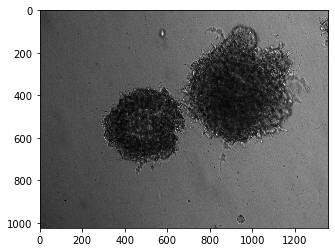

In [19]:
""" 
OpenCV preprocessing code
"""
# Gausian blur not necessary
# OG test impath: r"C:\Users\tomas\OneDrive\Documents\Terasom\Projects\Company\5T4\raw\wet\Imaging - spheroids\120hr\H1299\KD\3.jpg"
impath = r"G:\Shared drives\Backup\Tomas\Terasom\Projects\Company Projects\5T4\raw\wet\Imaging - spheroids\48hr\H1299\KD\9.jpg"
#impath = r"G:/Shared drives/Backup/Tomas/Terasom/Projects/Company/5T4/raw/wet/Imaging - spheroids/120hr/H1299/KD/3.jpg"
image = cv2.imread(impath)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # convert to grayscale
blurred = cv2.GaussianBlur(gray, (11, 11), 0) # keep, it's a good thing for area estimation in the final step
ij.py.show(gray,cmap = "gray")

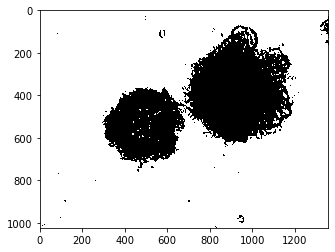

In [20]:
# OpenCV adaptive thresholding to convert to binary and account for the gradient
#blurred instead of gray
thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 1701, 7) # 1700ish seems good;larger round numbers don't work, so I added that pesky 1 as a workaround.
ij.py.show(thresh, cmap = "gray") # when "gray" isn't specified,the image shows up as yellow/purple; not cool

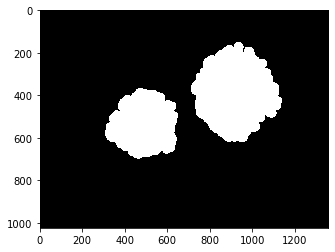

numpy.ndarray

In [21]:
# Image for mask --> takes thresh, closes (close operation) it with a 42^2 kernel, and makes round objects; may have to adjust for other images  
kernelSize = (42,42) # modifyable size of kernel to use for ellipse formation; OG = (42,42)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernelSize) # ellipse seems more relevant than rectangle
thresh_closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
thresh_closed = cv2.bitwise_not(thresh_closed) # inverts b/w; find.contours uses inverted
contour,hier = cv2.findContours(thresh_closed,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
for cnt in contour:
    cv2.drawContours(thresh_closed,[cnt],0,255,-1)
ij.py.show(thresh_closed, cmap = "gray")
type(thresh_closed)

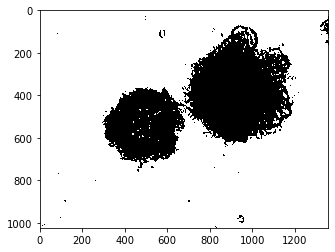

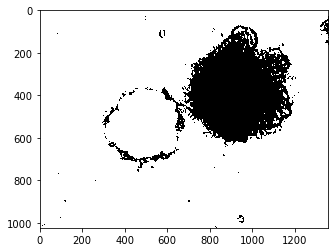

In [22]:
# Contours and mask using for thresh_closed
contours, hierarchy = cv2.findContours(thresh_closed, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE) 
mask = np.zeros(thresh_closed.shape, np.uint8)
# sort contours and remove the largest
sorted_areas = sorted(contours, key=cv2.contourArea)
n = len(contours)-1 # generalised indexer, irrespective of overall number of contours
secondary_areas = sorted_areas[0:n] # gathers all contours except the largest one, i.e. our center 
cv2.drawContours(mask, secondary_areas, -1, (255), -1) # -1 = all; 255 = colour; -1 = dunno, but won't work without this
removed = cv2.add(thresh, mask)
ij.py.show(thresh, cmap = "gray")
ij.py.show(removed, cmap = "gray")
    

In [23]:
imp = ij.py.to_imageplus(removed) # converts to ImageJ readable format
ij.IJ.run(imp,"Analyze Particles...", "size=1e5-Infinity circularity=0.00-1.00 show=[Overlay] display clear include composite")
ijresults = ij.ResultsTable.getResultsTable()
stats_ij = defaultdict(list)
for column in ijresults.getHeadings():
    stats_ij[column].append(ijresults.getColumn(column)[0])
df_ij = DataFrame(stats_ij)
IJ_output = df_ij["Area"].loc[0]
ij.IJ.run(imp,"Close", "") # test to see if important in batch mode

IJ_gather = np.array([('Rex', IJ_output)], dtype=[('name', 'U10'), ('area', 'f4')])
print(IJ_gather)
cv2.imwrite(r"C:\Users\tomas\OneDrive\Documents\Terasom\Projects\Company\5T4\raw\wet\Imaging - spheroids\120hr\Panc1\KD\test.jpg", removed)

Operating in headless mode - the original ImageJ will have limited functionality.
Operating in headless mode - the IJ class will not be fully functional.
[java.lang.Enum.toString]  	Area	Mean	Min	Max[java.lang.Enum.toString] 
[java.lang.Enum.toString] 1	195897	9.479	0	255[java.lang.Enum.toString] 
Operating in headless mode - the ResultsTable class will not be fully functional.


[('Rex', 195897.)]


False

In [1]:
### General comments
# sys.path.insert(0, r"C:\Users\tomas\miniconda3\Lib\site-packages") # package bypass for the pyimagej environment
    # 22/7/22 - hashed out bc no longer an issue. Did a clean instal of miniconda and installed OpenCV\\MatplotLib into the PyImageJ envi
# Base python v3.9.12 (27/7/22)

### ImageJ gateway
import imagej # v1.2.1; if you import it multiple times, it will stop working and you'll have to restart the kernel.
ij = imagej.init() # IJ2 = enough, don't need Fiji; headless = True is default 

### Imports
import cv2 # v4.6.0 (27/7/22)
import numpy as np # v1.23.1 (27/7/22)
import re # v2.2.1 (27/7/22)
import tkinter as tk # no version attributes
from tkinter import simpledialog # ditto as above; this creates a user input box for the path variable
import sys, traceback, subprocess, os # no version attributes
from pandas import DataFrame # no version attributers
from collections import defaultdict # no version attributes

### Custum functions
def directory_prompt():
    global directory
    qbox = tk.Tk()
    qbox.geometry("1000x250")
    qbox.withdraw()
    qbox_input = simpledialog.askstring(title="Path input",prompt="What directory do you want to be analysed? The current directory is: \n" + directory)
    directory = str(qbox_input)
    
def imgname_extractor(file):
    matcher = re.compile(imgname_pattern)
    matchResult = matcher.search(file)
    if matchResult != None:
        global imgname
        imgname = matchResult.group(1) # image name of image file for later use
    else:
        pass
    
def img_preprocessing(path):
    global image
    image = cv2.imread(path) #image being used; variable name is overwritten to prevent memory cluttering
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # convert to grayscale
    image = cv2.GaussianBlur(image, (11, 11), 0) # keep, it's a good thing for area estimation in the final step
    image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 1701, 7) # 1700ish seems good;larger round numbers don't work, so I added that pesky 1 as a workaround.   
    
def mask_create(): # prepares a mask
    global mask
    kernelSize = (42,42) # modifyable size of kernel to use for ellipse formation; OG = (42,42)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernelSize) # ellipse seems more relevant than rectangle
    mask = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    mask = cv2.bitwise_not(mask) # inverts b/w; find.contours uses inverted
    contour,hier = cv2.findContours(mask,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contour: # fills in holes in mask in case that's where the contours be at
        cv2.drawContours(mask,[cnt],0,255,-1)
    
def mask_to_image(): # removes the spheroid and applies the mask
    # Contours and mask using for thresh_closed
    global mask
    global image
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    mask = np.zeros(mask.shape, np.uint8)
    sorted_areas = sorted(contours, key=cv2.contourArea)
    n = len(contours)-1 # generalised indexer, irrespective of overall number of contours
    sorted_areas = sorted_areas[0:n] # gathers all contours except the largest one, i.e. our center; once again: conserves memory
    cv2.drawContours(mask, sorted_areas, -1, (255), -1) # -1 = all; 255 = colour; -1 = dunno, but won't work without this
    image = cv2.add(image, mask)

def ij_measure_area(): # functionising IJ like this seems to break it; kernel needs restarting after running the code
    global image
    global IJ_output
    imp = ij.py.to_imageplus(image) # converts to ImageJ readable format
    ij.IJ.run(imp,"Analyze Particles...", "size=1e5-Infinity circularity=0.00-1.00 show=[Overlay] display clear include composite");
    ijresults = ij.ResultsTable.getResultsTable()
    stats_ij = defaultdict(list) # create workable dictionary; might want to do this in a more elegant way?
    for column in ijresults.getHeadings():
        stats_ij[column].append(ijresults.getColumn(column)[0])
    stats_ij = DataFrame(stats_ij)
    stats_ij = int(stats_ij["Area"].loc[0])
    IJ_output = np.append(IJ_output, [[str(imgname), str(stats_ij)]], axis = 0)
    ij.IJ.run(imp,"Close", "") #is this important? does it help or is pyimagej still broken even with this incorporated?

In [3]:
### Variables
directory = r"C:\Users\tomas\OneDrive\Documents\Terasom\Projects\Company\5T4\raw\wet\Imaging - spheroids\48hr\H1299\WT"
imgname_pattern = '^(.+)(?:.jpg)$' # pattern for capturing the name of the image file for later use
IJ_output = np.array([['filename', 'area in pix^2']])

# check it out
#directory_prompt()
for file in os.listdir(directory):
    PathToImage_current = os.path.join(directory, file)
    if os.path.isfile(PathToImage_current):
        imgname_extractor(file)
        img_preprocessing(PathToImage_current)
        mask_create()
        mask_to_image()
        ij_measure_area();
    else:
        print("done!")
location = os.path.join(directory, "SpheroidAreas.csv")
np.savetxt(location, IJ_output, delimiter=',', fmt='%s') #is unsorted, tho 

# FIX ASAP --> 

[java.lang.Enum.toString]  	Area	Mean	Min	Max[java.lang.Enum.toString] 
[java.lang.Enum.toString] 1	118971	10.447	0	255[java.lang.Enum.toString] 
[java.lang.Enum.toString]  	Area	Mean	Min	Max[java.lang.Enum.toString] 
[java.lang.Enum.toString] 1	143596	2.768	0	255[java.lang.Enum.toString] 
[java.lang.Enum.toString]  	Area	Mean	Min	Max[java.lang.Enum.toString] 
[java.lang.Enum.toString] 1	110906	6.645	0	255[java.lang.Enum.toString] 
[java.lang.Enum.toString]  	Area	Mean	Min	Max[java.lang.Enum.toString] 
[java.lang.Enum.toString] 1	132850	1.607	0	255[java.lang.Enum.toString] 
[java.lang.Enum.toString]  	Area	Mean	Min	Max[java.lang.Enum.toString] 
[java.lang.Enum.toString] 1	163710	2.587	0	255[java.lang.Enum.toString] 
[java.lang.Enum.toString]  	Area	Mean	Min	Max[java.lang.Enum.toString] 
[java.lang.Enum.toString] 1	138386	4.150	0	255[java.lang.Enum.toString] 
[java.lang.Enum.toString]  	Area	Mean	Min	Max[java.lang.Enum.toString] 
[java.lang.Enum.toString] 1	259507	4.761	0	255[java.lang.

In [ ]:
import tkinter as tk
from tkinter import simpledialog
